# AIC (Akaike Information Criteria) and BIC (Bayesian Information Criteria) 
### Exploring AIC and BIC as tools for selecting the number of components and testing for overfitting



In this notebook we're going to load up the same examples as the walk-through and explore the correlation between BIC and AIC values and the PerVect approximation of PerWass.  Later, we'll split up some train/test sets and see what happens when we try to really really overfit the data.  We'lll see that changes in the BIC are correlated to changes in the model accuracy (increasing the number of components does not monotonically improve the model but we are taking about fractions of a percent), and explore what happens under extreme overfitting. 

At the end of the day, it seems like maximizing the gradient of BIC is a fine way to go to approximate the number of componenents to use.  There are several other options available for optimizing the number of componenents in a GMM, any of which would likely do well in selecting the number of components in PerVect as well.  As we saw in the walkthough notebook, even with alarmingly few components we could still seperate the 6 classes of objects quite easily and approximate Wasserstein distance remarkably well. 

As for overfitting, even with very few samples, it was very challenging to overfit even a small subset of the data.  We were able to get 0.99 correlation (or above) with true Wasserstein distance on a test set having trained PerVect on only 15 diagrams. It would be interesting to see how well this would perform on noisy 'real world' data.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import pairwise_distances
from pervect import PersistenceVectorizer
from pervect import wasserstein_diagram_distance
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import ot
import scipy

In [2]:
def all_pairs_wass(dgms, y_axis='death'):
    n = len(dgms)
    distance_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            distance_matrix[i,j] = wasserstein_diagram_distance(
                                                dgms[i], dgms[j], y_axis=y_axis)
            distance_matrix[j,i] = distance_matrix[i,j]
    
    return distance_matrix


## Adding the example diagrams


Teaspoon is a package for doing various TDA stuff. Code is [here](https://github.com/lizliz/teaspoon).  Someday it will be set up to do pip install.  Today is not that day.

In [3]:
from teaspoon.MakeData.PointCloud import testSetManifolds 
from teaspoon.TDA.Distance import dgmDist_Hera

Were are going to generate 100 small examples from each of the 6 classes

In [4]:
%%time
manifoldData = testSetManifolds(numDgms = 100, numPts = 300, permute = False, seed = 0)

Generating torus clouds...
Generating annuli clouds...
Generating cube clouds...
Generating three cluster clouds...
Generating three clusters of three clusters clouds...
Generating sphere clouds...
Finished generating clouds and computing persistence.

CPU times: user 3min 24s, sys: 2.58 s, total: 3min 26s
Wall time: 53.2 s


In [5]:
# We are just going to consider the 1-dimension persistence 
# In birth-death alignment
JustDgms_death = list(manifoldData['Dgm1'])


#### Here's the complete data for all of the Dgms (with y_axis = 'death')

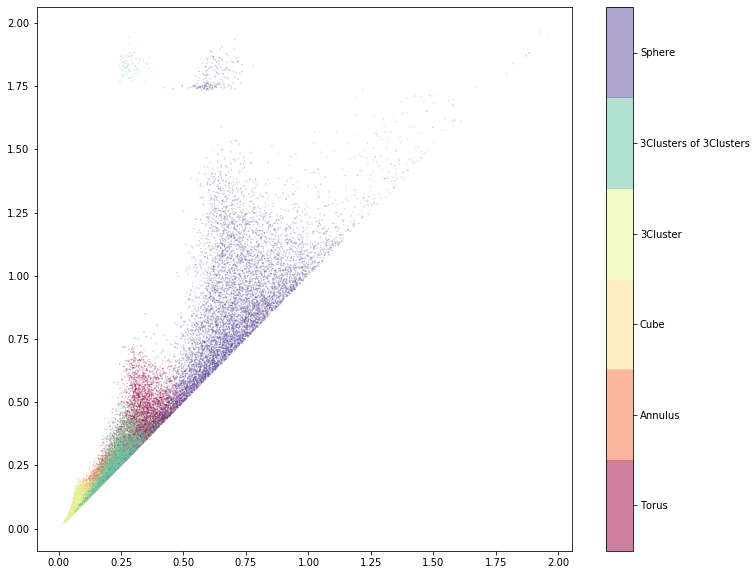

In [6]:
combined_data = np.vstack(JustDgms_death)
labels = np.hstack([np.full(len(JustDgms_death[i]), i//100) for i in range(len(JustDgms_death))])
plt.figure(figsize=(12,10))
plt.scatter(*combined_data[::-1].T, s=0.1, c=labels, cmap='Spectral', alpha=0.5)
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(manifoldData.trainingLabel.unique())

We'll compute all pairwise PerWass distances between the diagrams for future comparison

In [7]:
%%time
wass_all_pairs_dist = all_pairs_wass(JustDgms_death)

CPU times: user 2min 52s, sys: 1.64 s, total: 2min 54s
Wall time: 2min 50s


# AIC (Akaike Information Criteria) and BIC (Bayesian Information Criteria) 

#### To start, we are going to look at the AIC and BIC for our full data set to see what they predict as the 'correct' number of bins

For reference here are the number of features per diagram

In [8]:
n_features = [diagram.shape[0] for diagram in JustDgms_death]
print("MIN: " , np.min(n_features))
print("AVG: " , int(np.average(n_features)))
print("MAX: " , np.max(n_features))

MIN:  36
AVG:  67
MAX:  98


#### We'll explore all the options between 2 and 40 bins which, given the distribution above, should be more than enough

In [9]:
%%time 
models = [PersistenceVectorizer(n_components=i, y_axis='death').fit(JustDgms_death) for i in range(2,40)]

CPU times: user 6min 26s, sys: 4.67 s, total: 6min 31s
Wall time: 1min 42s


In [10]:
%%time 
bics = [m.mixture_model_.bic(combined_data) for m in models]
aics = [m.mixture_model_.aic(combined_data) for m in models]

CPU times: user 13.3 s, sys: 858 ms, total: 14.2 s
Wall time: 3.55 s


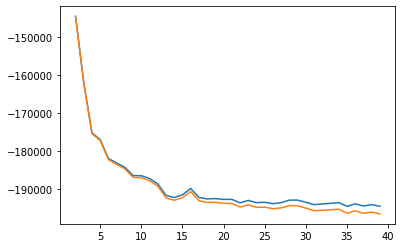

In [11]:
plt.plot([len(m.mixture_model_.means_) for m in models], bics)
plt.plot([len(m.mixture_model_.means_) for m in models], aics)

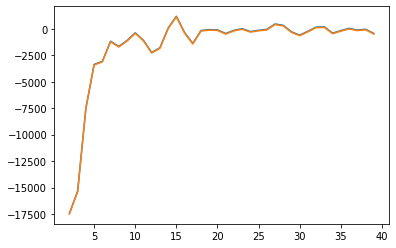

In [12]:
plt.plot([len(m.mixture_model_.means_) for m in models], np.gradient(bics))
plt.plot([len(m.mixture_model_.means_) for m in models], np.gradient(aics))

In [13]:
models[np.argmax(np.gradient(bics))].n_components

15

It seems like we're getting just about everything we can out of this model at around 15 dimensions (randomness changes the exact value), after that the returns just aren't worth it (according to the BIC and AIC).  Using about 9 and 18 dimensions also look like good choices being local maxima close to the global. 

### Lets see where the Gaussians end up for that strange zig-zag range (14-17 components)

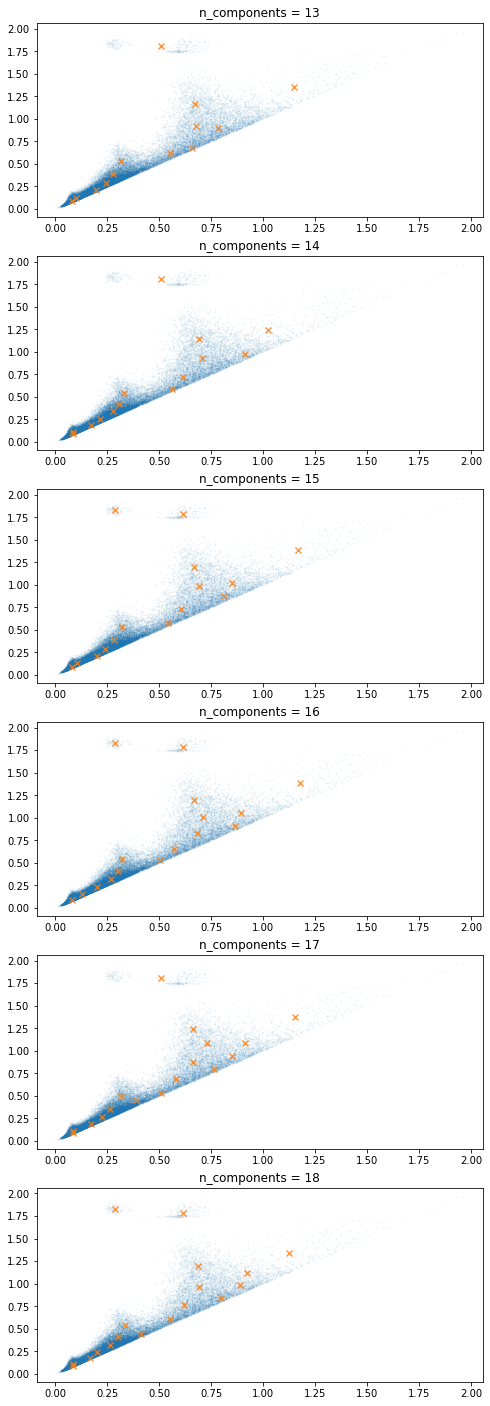

In [14]:
min_bins = 13
max_bins = 18
fig, axes = plt.subplots( (max_bins-min_bins+1) ,1,  figsize = (8,25))
labels = np.hstack([np.full(len(JustDgms_death[i]), i//100) for i in range(len(JustDgms_death))])
for i in range(min_bins-2, max_bins-1):
    means=models[i].mixture_model_.means_
    axes[i-min_bins+2].scatter(*combined_data[::-1].T, s=0.5, alpha=0.05)
    axes[i-min_bins+2].scatter(*means.T, marker="x", cmap='reds', alpha=0.8)
    axes[i-min_bins+2].set_title('n_components = ' + str(len(means)))
plt.show()

Basically the instability stems from the model 'deciding' between using 1 or 2 bins high off the life-time=0 line ... makes sense... it can't be a perfectly monotonic increase in model accuracy; EM and K-means initialization just aren't good enough for that demanding task (and we're talking about very marginal differences). Perhaps with a different initialization the GMM would have chosen 2 bins up top slightly earlier and have done even better - it would be tough to force that and we are really talking about marginal gains. 

### Now lets see how well the BIC is correlated with accuracy (it should be)

In [15]:
%%time
reduced_test_dgm=[JustDgms_death[5*i] for i in range(len(JustDgms_death) // 5)]
all_dists=[model.pairwise_p_wasserstein_distance(reduced_test_dgm) for model in models]
all_pairs_dist = all_pairs_wass(reduced_test_dgm)

CPU times: user 50 s, sys: 181 ms, total: 50.2 s
Wall time: 49.5 s


In [16]:
r_vals=[scipy.stats.pearsonr(dist.flatten(), all_pairs_dist.flatten()) for dist in all_dists]

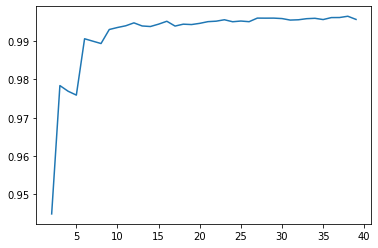

In [17]:
plt.plot([len(m.mixture_model_.means_) for m in models], [r[0] for r in r_vals] )

This looks correlated to the BIC and AIC values and so they likely serve as a decent proxy for accuracy.

In [18]:
print(scipy.stats.kendalltau([r[0] for r in r_vals], bics))
print(" ")
print("PearsonrResult",scipy.stats.pearsonr([r[0] for r in r_vals], bics))
print(' ')
print(scipy.stats.spearmanr([r[0] for r in r_vals], bics))

KendalltauResult(correlation=-0.6842105263157895, pvalue=1.4748886048043324e-09)
 
PearsonrResult (-0.9514221507860099, 5.28959030511482e-20)
 
SpearmanrResult(correlation=-0.8632235474340738, pvalue=3.1174123690437134e-12)


## Lets experminent with over fitting.... and let's make it hard on ourselves

Let's try and fit just 10% of the data and see how well we compute distances on the remaining.  We'll consider the AIC, BIC, and the correlation between PerWass and PerVect distances on 1/5 of the test data (which will be enough... computing all pairwise distances is tedious). 

In [19]:
full_labels = np.hstack([i*np.ones(100) for i in range(6)])
train_dgm, test_dgm, train_labels, test_labels = train_test_split(JustDgms_death, full_labels, train_size=0.1, random_state=42)
combined_train_data=np.vstack(train_dgm)
print(len(combined_train_data))

3946


In [20]:
# Make sure we got a bit of everthing since we are only taking a small number of samples
np.unique(train_labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([11,  9,  8, 12, 12,  8]))

We're to use models with 5 to 195 components in increments of 10. 

In [21]:
%%time
models = [PersistenceVectorizer(n_components=10*i+5, y_axis='death').fit(train_dgm) for i in range(20)]

CPU times: user 2min 27s, sys: 959 ms, total: 2min 28s
Wall time: 37.1 s


In [22]:
# We're going to test a smaller subset of the data which will be sufficient to see what's going on. 
reduced_test_dgm=[test_dgm[5*i] for i in range(len(test_dgm) // 5)]
reduced_test_labels=[test_labels[5*i] for i in range(len(test_dgm) // 5)]
combined_test_data=np.vstack(reduced_test_dgm)
bics = [m.mixture_model_.bic(combined_test_data) for m in models]
aics = [m.mixture_model_.aic(combined_test_data) for m in models]

In [23]:
# Make sure we took a representative sample
np.unique(reduced_test_labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([17, 21, 20, 20, 13, 17]))

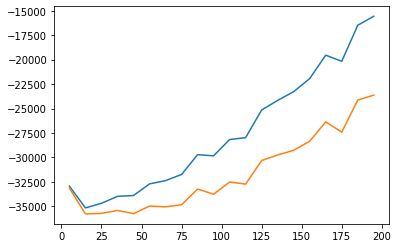

In [24]:
plt.plot([m.n_components for m in models], bics)
plt.plot([m.n_components for m in models], aics)

Looks like we're getting a good fit again around the 15 bin mark - we're also starting to see some signs of over fitting since the BIC and AIC are starting to really escalate.  Lets see how well these models approximate wasserstein distance on the test set.

In [25]:
%%time 
all_dists=[model.pairwise_p_wasserstein_distance(reduced_test_dgm) for model in models]

CPU times: user 2min 1s, sys: 577 ms, total: 2min 2s
Wall time: 2min 2s


In [26]:
%%time
all_pairs_dist = all_pairs_wass(reduced_test_dgm)

CPU times: user 6.05 s, sys: 43.3 ms, total: 6.1 s
Wall time: 5.57 s


In [27]:
r_vals=[scipy.stats.pearsonr(dist.flatten(),all_pairs_dist.flatten()) for dist in all_dists]

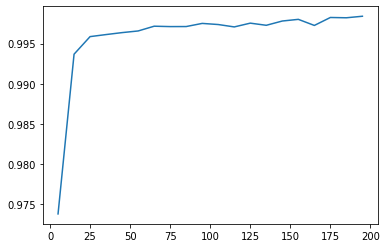

In [28]:
plt.plot([model.n_components for model in models], [r_vals[i][0] for i in range(len(r_vals))])

#### It still looks like it's converging so it seems we've still failed to overfit this data set (which is a good thing generically). 

### Let's turn this up to 11 and really try and overfit a tiny amount of data!

In [29]:
train_dgm, test_dgm, train_labels, test_labels = train_test_split(JustDgms_death, full_labels, train_size=0.025, random_state=10)
combined_train_data=np.vstack(train_dgm)
print(len(combined_train_data))

989


In [30]:
# Make sure we got a bit of everthing since we are only taking a TINY number of samples
np.unique(train_labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([3, 3, 2, 2, 3, 2]))

We're to use models with 5 to 765 components in increments of 40. 

In [31]:
%%time
models = [PersistenceVectorizer(n_components=40*i+5, y_axis='death').fit(train_dgm) for i in range(20)]

CPU times: user 1min 41s, sys: 938 ms, total: 1min 42s
Wall time: 27.9 s


In [32]:
# We're going to test a smaller subset of the data which will be sufficient to see what's going on. 
reduced_test_dgm=[test_dgm[10*i] for i in range(len(test_dgm) // 10)]
reduced_test_labels=[test_labels[10*i] for i in range(len(test_dgm) // 10)]
combined_test_data=np.vstack(reduced_test_dgm)
bics = [m.mixture_model_.bic(combined_test_data) for m in models]
aics = [m.mixture_model_.aic(combined_test_data) for m in models]

In [33]:
# Make sure we took a representative sample
np.unique(reduced_test_labels, return_counts=True)

(array([0., 1., 2., 3., 4., 5.]), array([11, 11, 10, 10,  8,  8]))

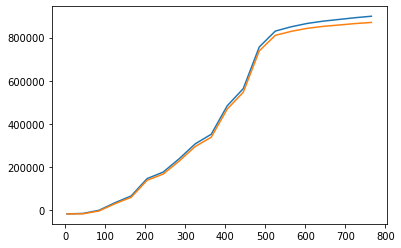

In [34]:
plt.plot([len(m.mixture_model_.means_) for m in models], bics)
plt.plot([len(m.mixture_model_.means_) for m in models], aics)

The BIC and AIC are starting to escsalate orders of magnitude and then stabilizing.  Lets see how well these models approximate wasserstein distance on the test set.

In [35]:
%%time 
all_dists=[model.pairwise_p_wasserstein_distance(reduced_test_dgm) for model in models]

CPU times: user 8min 9s, sys: 4.64 s, total: 8min 14s
Wall time: 4min


In [36]:
%%time
all_pairs_dist = all_pairs_wass(reduced_test_dgm)

CPU times: user 2.92 s, sys: 21.3 ms, total: 2.95 s
Wall time: 1.54 s


In [37]:
r_vals=[scipy.stats.pearsonr(dist.flatten(), all_pairs_dist.flatten()) for dist in all_dists]

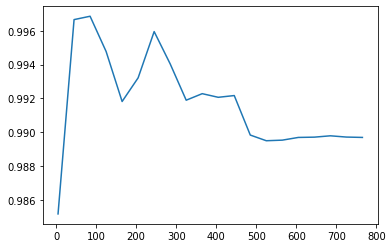

In [38]:
plt.plot([model.n_components for model in models], [r_vals[i][0] for i in range(len(r_vals))])

Finally we're starting to see the model over fit and converge to ONLY 0.990 accuracy. Let's see how the pairs plot looks with the true distances. 

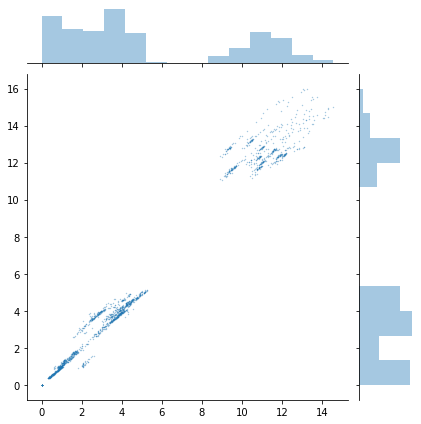

In [39]:
sns.jointplot(all_dists[19].flatten(), all_pairs_dist.flatten(), joint_kws={'s':0.1, 'alpha':0.3})

# Viewing diagrams as heatmaps of the GMM to try and see where it over fits

Our vectorization are the weights of a gmm (rescaled appropriately) so we can take a heat map of the correspoonding mixture of gaussians and see how well this visually approximates the actual diagram. 

In [40]:
x_max = max([j[:,0].max() for j in JustDgms_death])*1.05
y_max = max([j[:,1].max() for j in JustDgms_death])*1.05

In [41]:
def diagram_to_heatmap(diag, gmm, n_cells=300):
    xs = np.arange(0,x_max, x_max/n_cells)
    ys = np.arange(0,y_max, y_max/n_cells)
    a, b = np.meshgrid(xs,ys)
    mat = gmm.score_samples(np.column_stack((a.flatten(),b.flatten()))).reshape((n_cells,n_cells))
    # the score is the log likelihood so we have to fix that and flip the y_axis 
    #    and we rescale with log(1+x) for visualization ease 
    return np.flip(np.log1p(np.exp(mat)), axis = 0)

#### We'll set the models to be the one with 45 bins and the one with 765 check how this compares to a diagram of each type on the test set

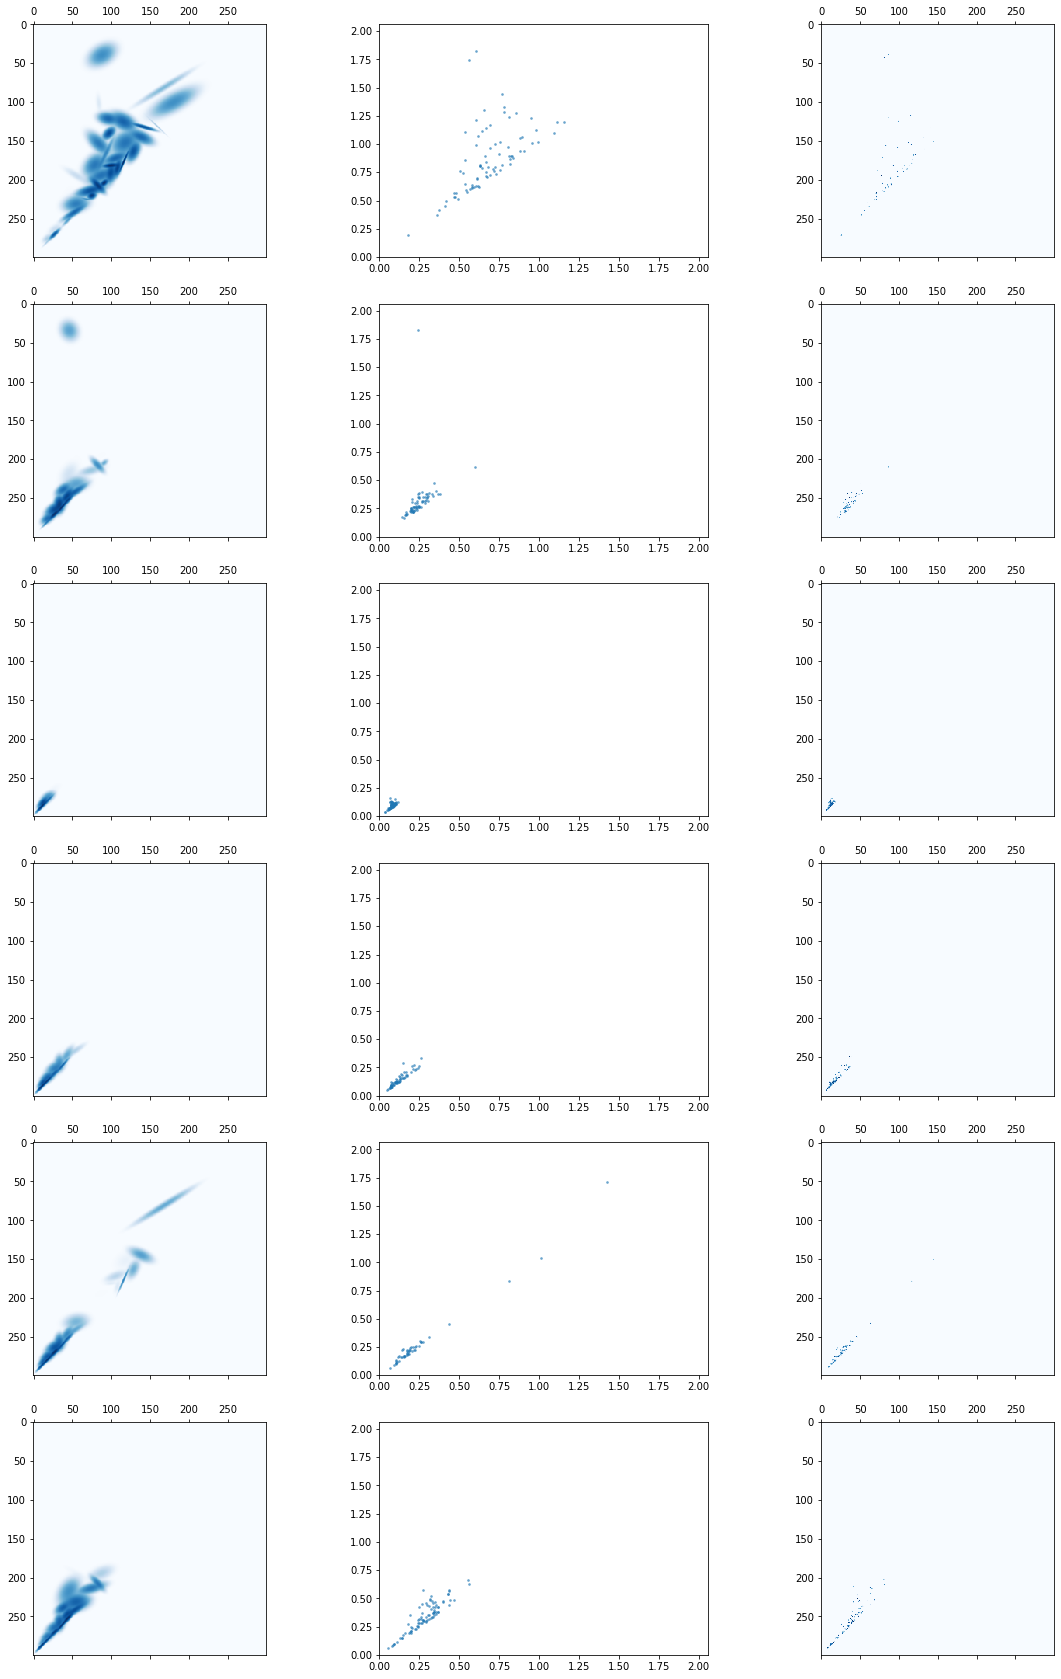

In [42]:
model = models[1]
model2 = models[19]

# pick a collection of diagrams

fig_ind = np.array([np.argmax(test_labels == i) for i in range(6)])

fig, axes = plt.subplots(6,3, figsize = (20,30))
for i in range(6) :
    diag_number = fig_ind[i]
    my_gmm = model.mixture_model_
    my_gmm.weights_ = model.transform([test_dgm[diag_number]])+1e-80 # The gmm evaluation hates zero weights
    hmap = diagram_to_heatmap(JustDgms_death[diag_number], my_gmm)
    my_gmm2 = model2.mixture_model_
    my_gmm2.weights_ = model2.transform([test_dgm[diag_number]])+1e-80 # The gmm evaluation hates zero weights
    hmap2 = diagram_to_heatmap(test_dgm[diag_number], my_gmm2)
    axes[i,0].matshow(hmap, cmap="Blues")
    axes[i,1].scatter(*test_dgm[diag_number].T, s=3, alpha=0.5)
    axes[i,1].axis([0,x_max,0,y_max])
    axes[i,2].matshow(hmap2, cmap="Blues")

We can see that the over fit model on the right is 'missing' points in some of the diagrams.

As we get more Gaussians we converge to diracs (or as close as machine precision allows) and so our model with too many components can't 'smoothly' count the mass of the points accross the components in the model.  Each of these points is sufficiently far from all the Gaussians, which all have epsilon covariances, that they are essentially equally likeliy to have been drawn from any of them (an equally infinitesimal chance) and hence it's information is effectly lost. 